In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

In [2]:
"""Parameterization"""
import numpy as np
t = np.arange(1, 170+1, 1) # array of timepoints at which to compute the antibody concentration
N = 10 # number of antibody classes
t_max = 14*np.ones(N) # time for the peak of antibody concentration for each antibody class
t_half = 48*np.ones(N) # antibody half-life for all antibody classes, respecively
params_dic = {"t_max":t_max, "t_half":t_half}

In [3]:
"""Compute Antibody concentration"""
from Methods.PK import Antibody
is_log = False # if True, it returns the log of the antibody concentration
dataname = "Ab_%d"%N
solver = "lm" # root solver method for finding absorption rate ka (see scipy.optimize.root)
c_t, c_dframe, ka, ke = Antibody(t = t, params_dic = params_dic, is_log = is_log, save_to = "Data/"+dataname+".csv", ka_solver = solver)
print(c_dframe, "k_a:", ka, "k_e:", ke)


 k_a was found correctly: True 

     Days      Ab_1      Ab_2      Ab_3      Ab_4      Ab_5      Ab_6  \
0       1  0.223579  0.223579  0.223579  0.223579  0.223579  0.223579   
1       2  0.402809  0.402809  0.402809  0.402809  0.402809  0.402809   
2       3  0.545897  0.545897  0.545897  0.545897  0.545897  0.545897   
3       4  0.659540  0.659540  0.659540  0.659540  0.659540  0.659540   
4       5  0.749201  0.749201  0.749201  0.749201  0.749201  0.749201   
..    ...       ...       ...       ...       ...       ...       ...   
165   166  0.119874  0.119874  0.119874  0.119874  0.119874  0.119874   
166   167  0.118156  0.118156  0.118156  0.118156  0.118156  0.118156   
167   168  0.116462  0.116462  0.116462  0.116462  0.116462  0.116462   
168   169  0.114792  0.114792  0.114792  0.114792  0.114792  0.114792   
169   170  0.113146  0.113146  0.113146  0.113146  0.113146  0.113146   

         Ab_7      Ab_8      Ab_9     Ab_10  
0    0.223579  0.223579  0.223579  0.223579

(<Figure size 1400x700 with 1 Axes>,
 <AxesSubplot:xlabel='time (days)', ylabel='$c_t$ (normalized)'>)

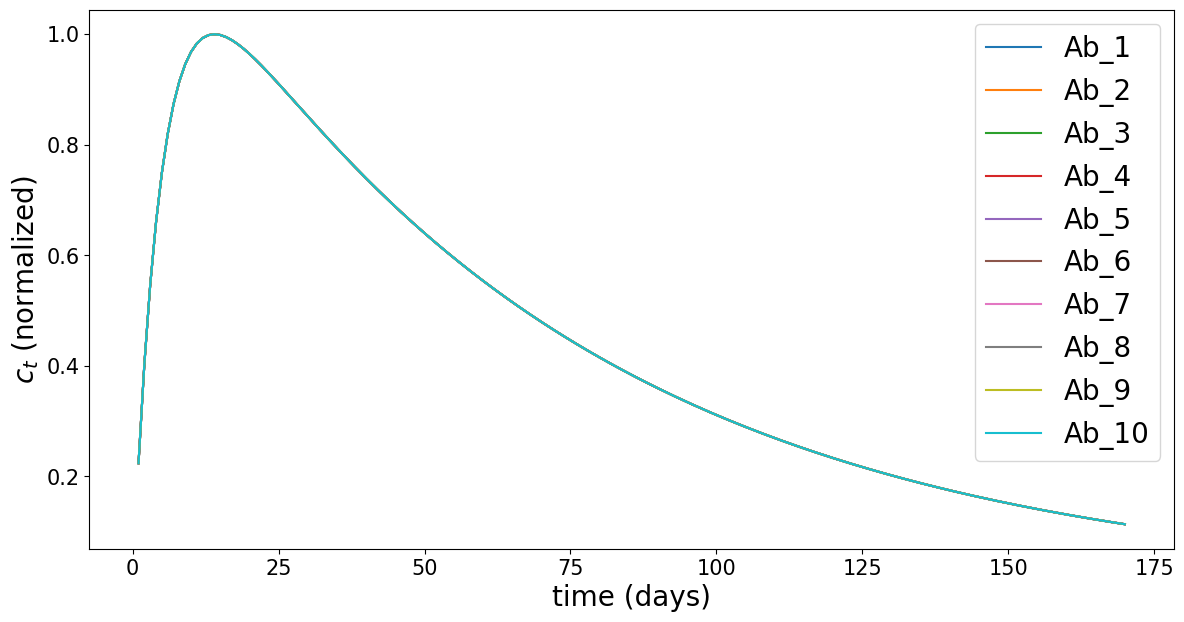

In [4]:
"""Plot Antibody concentration only if t is an array and save, default png but add extension .pdf to save as pdf"""
from Methods.figure_settings import Display
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (14, 7) # figure (width, height)
labels = c_dframe.columns[1:] # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "$c_t$ (normalized)" # name of variable on y axis
Display(t, c_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/"+dataname+".pdf",
        xval = xval, yval = yval)

In [5]:
"""Set up the vaccine efficacy data which is used for fitting"""
from Methods.VE import sqrt_diff, vaccine_efficacy_four_antibodies, vaccine_efficacy_n_antibodies
import matplotlib.pyplot as plt

days = np.array([1,2,3,4,5,6])*28
ve_data_1 = np.array([87.6, 73.3, 62.4, 35.1, 20.4, 17.9])/100
ve_data_2 = np.array([0.92423, 0.87141, 0.76936, 0.59191, 0.52525])
ve_data = [ve_data_1, ve_data_2]

[0.20118341]
[0.51119209]
[0.83920279]
[1.1806477]
[1.5296183]


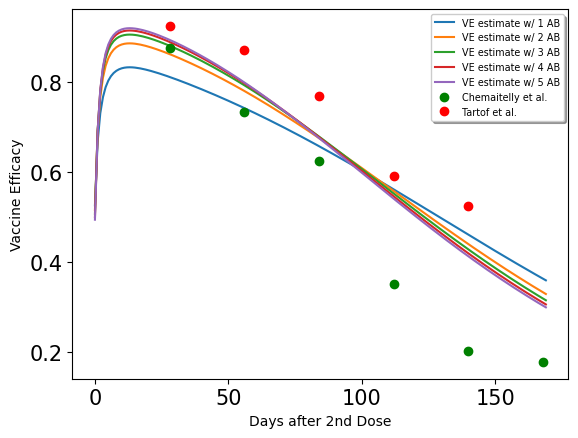

In [6]:
"""Fit the data using n=1,2,3,...,10 antibodies"""
from scipy.optimize import root

guess = 0.2
for n in range(1,6):
    ic50 = root(sqrt_diff, guess, args = (days, ve_data, n, c_dframe), method = "lm").x
    print(ic50)
    ve_estimate = np.zeros(170)
    for i in range(170):
        antibody_level = c_dframe.loc[i][1:n+1]
        ve_estimate[i] = vaccine_efficacy_n_antibodies(antibody_level, ic50)
    plt.plot(range(170), ve_estimate, label = "VE estimate w/ "+ str(n) + " AB")

plt.plot(days, ve_data_1,'go', label = "Chemaitelly et al.")
plt.plot(days[0:5], ve_data_2, 'ro', label = "Tartof et al.")
plt.xlabel("Days after 2nd Dose")
plt.ylabel("Vaccine Efficacy")
plt.legend(loc='upper right', shadow=True, fontsize='x-small')

In [7]:
np.random.seed(7)
infection_data = np.random.randint(100000, size=170)
reduction_in_infection_prob = 0
for i in range(170):
    reduction_in_infection_prob += infection_data[169-i] * ve_estimate[i]
print(reduction_in_infection_prob/sum(infection_data))

0.6349044776751117


In [8]:
from Methods.VE import expected_reduction_infection_prob
print(expected_reduction_infection_prob(ic50, range(170), infection_data, 5, c_dframe))

[0.63490448]


In [9]:
""" Projection of Neutralization probability as a function of COV19 variant proportions """
infected = infection_data
variant_name = ["Var 1", "Var 2", "Var 3", "Var 4"]
variant_proportion = np.tile(np.array([0.05, 0.20, 0.60, 0.15]), (len(t), 1)) # variant proportion might change over time
fold_resistance = [1.2, 1.4, 1.6, 1.8]

variant_data = {"name":variant_name, "proportion":variant_proportion, "fold resistance":fold_resistance}
antibody_data = {"t_max": t_max, "t_half":t_half}
VE_data_wild = {"days":days, "Neut":ve_data}

In [10]:
from Methods.PN_Projection import Neut_Total
PN_dic = Neut_Total(t, infected, antibody_data, VE_data_wild, variant_data)


 k_a was found correctly: True 



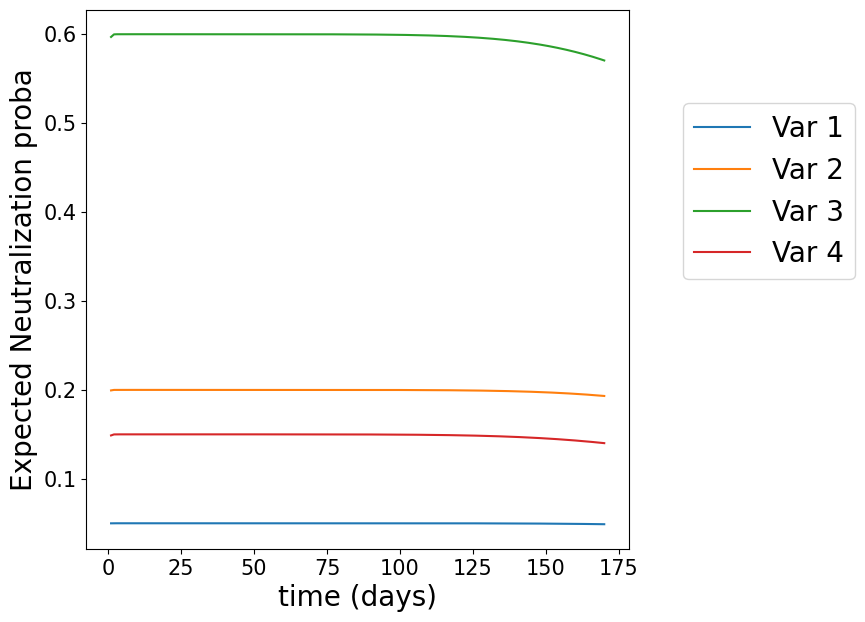

In [11]:
"""Plot Projection, default png but add extension .pdf to save as pdf"""
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (7, 7) # figure (width, height)
labels = variant_name # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "Expected Neutralization proba" # name of variable on y axis
neut_t = np.row_stack(tuple([PN_dic[variant_name[i]] for i in range(len(variant_name))]))
prob_neut_t = neut_t/infected
Display(t, prob_neut_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/Neut_Projection.pdf",
        xval = xval, yval = yval)
plt.legend(fontsize = labsize, loc = (1.1, 0.5))

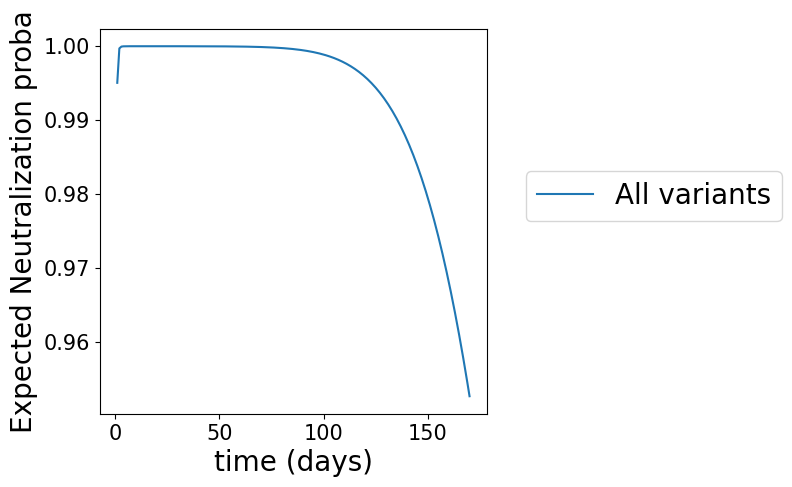

In [16]:
"Total projected neutralization proba"
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (5, 5) # figure (width, height)
labels = ["All variants"] # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "Expected Neutralization proba" # name of variable on y axis
neut_t = np.row_stack(tuple([PN_dic[variant_name[i]] for i in range(len(variant_name))]))
tot_prob_neut_t = np.array([np.sum(neut_t/infected, axis = 0)])
Display(t, tot_prob_neut_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/Total_Neut_Projection.pdf",
        xval = xval, yval = yval)
plt.legend(fontsize = labsize, loc = (1.1, 0.5))